### Simple detector for experiments : 1) loss function 2)head 3)feature extrator 4) augmentation
### Just 10 epoch with lr = 0.001 (near 20 min) - and we get detector from scratch. Using pre-trained feature-extractor(for loss function and head experiments) - even faster

In [1]:
import sys
import os, sys, tarfile
import numpy as np
import matplotlib.pyplot as plt
import urllib
from PIL import Image
from keras.optimizers import RMSprop, SGD

from keras.models import load_model
import keras.backend as K
import data_preprocessing, data_generator, visual, label_parser, data_postprocessing
import pdb
import tensorflow as tf

%matplotlib inline

%load_ext autoreload
%autoreload 2
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

C:\Users\Vital\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TRAIN_PATH = 'C:/datasets/mickey_dataset/train/'
TEST_PATH = 'C:/datasets/mickey_dataset/train/'

In [3]:
train_ann = label_parser.parse_annotation_json(TRAIN_PATH)
test_ann = label_parser.parse_annotation_json(TEST_PATH)
print("len(train_ann) = ",len(train_ann))
print("len(test_ann) = ", len(test_ann))

len(train_ann) =  100
len(test_ann) =  100


In [5]:
size = 112
config_train = {'grid_w':7, 'grid_h':7, 'img_w' : size, 'img_h' : size, 'is_augment' : False, 'batch_size' : 32}
config_test  = {'grid_w':7, 'grid_h':7, 'img_w' : size, 'img_h' : size, 'is_augment' : False, 'batch_size' : 100}

In [6]:
trainGenerator = data_generator.BatchGenerator(train_ann, config_train)
testGenerator = data_generator.BatchGenerator(test_ann, config_test)

iteration_num =  4
iteration_num =  1


In [7]:
import tensorflow as tf

config = tf.ConfigProto()    #to limit TensorFlow resources
config.gpu_options.allow_growth = True
tf.Session(config = config)

In [8]:
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Reshape, Activation, BatchNormalization

GRID_W = config_train['grid_w']
GRID_H = config_train['grid_h']
input_w = config_train['img_w']
input_h = config_train['img_h']

img_input = Input(shape=(input_w, input_h, 3), name = 'image_input')

#TODO - experiment with decreasing conv filter num
x = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same')(img_input)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D()(x) 

x = Conv2D(filters = 24, kernel_size = (3, 3), padding = 'same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D()(x) 

x = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D()(x) 

x = Conv2D(filters = 48, kernel_size = (3, 3), padding = 'same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D()(x) 

# x = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same')(x)
# x = BatchNormalization()(x)
# x = Activation("relu")(x)
# x = MaxPooling2D()(x) 

x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(5*GRID_W*GRID_H)(x)
x = Reshape((GRID_W, GRID_H, 5))(x)

model = Model(inputs=img_input, outputs=x)

In [9]:
import tensorflow as tf
def YOLO_loss(y_true, y_pred):
    mask_obj = K.expand_dims(y_true[..., 0], axis=-1)
    mask_no_obj = 1 - mask_obj
    loss_obj = K.sum(K.square(y_true-y_pred)*mask_obj)                             #Loss_xywhp for object
    loss_no_obj = K.sum(K.square(y_true[...,0]-y_pred[...,0])*mask_no_obj[...,0] ) #only confidence
    N_obj = tf.reduce_sum(tf.to_float(mask_obj > 0.0))
    N_no_obj = tf.reduce_sum(tf.to_float(mask_no_obj > 0.0))
    return loss_obj / (N_obj + 1e-06) + 5 * loss_no_obj / (N_no_obj + 1e-06)       #because only 1 from 5 values (p,x,y,w,h)

from keras.utils.generic_utils import get_custom_objects
from keras.models import load_model
get_custom_objects().update({"YOLO_loss": YOLO_loss})
model = load_model("YOLO_scratch", custom_objects={ 'loss': YOLO_loss } )

In [10]:
model.compile(loss=YOLO_loss, optimizer = SGD(lr=0.001, momentum=0.9), metrics=['accuracy'])

In [11]:
x_batch, y_batch = trainGenerator.__getitem__(0)
model.evaluate(x_batch, y_batch)

32/32 [==============================] - 0s 12ms/step


[5.9246602058410645, 0.19770407676696777]

In [12]:
from time import time
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
checkpoint = ModelCheckpoint("YOLO_scratch_overfit", monitor='val_loss', verbose=2, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [18]:
model.fit_generator(generator = trainGenerator, steps_per_epoch  = len(trainGenerator), epochs = 50, validation_data = testGenerator, verbose = 1, callbacks=callbacks_list)

Epoch 1/50
3/4 [=====================>........] - ETA: 1s - loss: 10.3938 - acc: 0.1918epoch is finished
epoch is finished
4/4 [==============================] - 5s 1s/step - loss: 9.2441 - acc: 0.1781 - val_loss: 5.4645 - val_acc: 0.1288

Epoch 00001: val_loss improved from inf to 5.46453, saving model to YOLO_scratch_overfit
Epoch 2/50
3/4 [=====================>........] - ETA: 0s - loss: 4.9392 - acc: 0.1278epoch is finished
epoch is finished
4/4 [==============================] - 4s 1s/step - loss: 4.6568 - acc: 0.1234 - val_loss: 3.5006 - val_acc: 0.0976

Epoch 00002: val_loss improved from 5.46453 to 3.50055, saving model to YOLO_scratch_overfit
Epoch 3/50
3/4 [=====================>........] - ETA: 0s - loss: 3.0476 - acc: 0.0925epoch is finished
epoch is finished
4/4 [==============================] - 4s 1s/step - loss: 2.9085 - acc: 0.0901 - val_loss: 2.4761 - val_acc: 0.0716

Epoch 00003: val_loss improved from 3.50055 to 2.47605, saving model to YOLO_scratch_overfit
Epoch 4


Epoch 00025: val_loss improved from 0.32521 to 0.31159, saving model to YOLO_scratch_overfit
Epoch 26/50
3/4 [=====================>........] - ETA: 0s - loss: 0.2883 - acc: 0.0738epoch is finished
epoch is finished
4/4 [==============================] - 4s 1s/step - loss: 0.2876 - acc: 0.0725 - val_loss: 0.2933 - val_acc: 0.0714

Epoch 00026: val_loss improved from 0.31159 to 0.29326, saving model to YOLO_scratch_overfit
Epoch 27/50
3/4 [=====================>........] - ETA: 0s - loss: 0.2794 - acc: 0.0740epoch is finished
epoch is finished
4/4 [==============================] - 4s 1s/step - loss: 0.2795 - acc: 0.0741 - val_loss: 0.2828 - val_acc: 0.0716

Epoch 00027: val_loss improved from 0.29326 to 0.28284, saving model to YOLO_scratch_overfit
Epoch 28/50
3/4 [=====================>........] - ETA: 0s - loss: 0.2699 - acc: 0.0753epoch is finished
epoch is finished
4/4 [==============================] - 4s 1s/step - loss: 0.2657 - acc: 0.0737 - val_loss: 0.2699 - val_acc: 0.0720



4/4 [==============================] - 4s 1s/step - loss: 0.1358 - acc: 0.0700 - val_loss: 0.1331 - val_acc: 0.0722

Epoch 00050: val_loss did not improve from 0.13227


only flip - 87s - no crash
flip + rotation - 231s - no crash
flip + width and height shift_range -  231s - no crash
flip +  shear_range zoom_range - 231s - no crash


112x112x3 (4 conv-pool) lr = 0.001 epoch - 90 sec, 10 epoch, loss - 0.3?, AP = 0.6?
224x224x3 (5 conv-pool) lr = 0.001, epoch - 120 sec, 3 epoch - loss 0.5, 10 epoch, loss - 0.26, AP = 0.66
20 epoch, loss = 0.1562, AP = 0.763

In [14]:
K.set_value(model.optimizer.lr, 0.0001)
model.fit_generator(generator = trainGenerator, steps_per_epoch  = len(trainGenerator), epochs = 10, validation_data = testGenerator, verbose = 1)

Epoch 1/10
624/625 [============================>.] - ETA: 0s - loss: 0.1479 - acc: 0.0676epoch is finished
epoch is finished
625/625 [==============================] - 184s 295ms/step - loss: 0.1479 - acc: 0.0676 - val_loss: 0.1654 - val_acc: 0.0657
Epoch 2/10
624/625 [============================>.] - ETA: 0s - loss: 0.1467 - acc: 0.0679epoch is finished
epoch is finished
625/625 [==============================] - 193s 308ms/step - loss: 0.1467 - acc: 0.0679 - val_loss: 0.1605 - val_acc: 0.0667
Epoch 3/10
624/625 [============================>.] - ETA: 0s - loss: 0.1462 - acc: 0.0676epoch is finished
epoch is finished
625/625 [==============================] - 179s 287ms/step - loss: 0.1462 - acc: 0.0676 - val_loss: 0.1630 - val_acc: 0.0664
Epoch 4/10
 25/625 [>.............................] - ETA: 1:35 - loss: 0.1419 - acc: 0.0670

KeyboardInterrupt: 

loss: 0.1340 - the best

In [15]:
model.save("YOLO_scratch2")

In [19]:
x_batch, y_batch = testGenerator.__getitem__(0)
img_num = 1
y_pred = model.predict(x_batch[img_num:img_num+1])
np.set_printoptions(precision=3, suppress = True)

print(y_pred[0,:,:,0])

[[ 0.149  0.192  0.033 -0.084 -0.174 -0.007  0.097]
 [-0.028 -0.094  0.216  0.129  0.325  0.053 -0.083]
 [ 0.044  0.052  0.184  0.076  0.824  0.035  0.016]
 [-0.13  -0.288  0.148  0.191  0.156 -0.013  0.042]
 [ 0.211  0.091  0.823  0.229 -0.155  0.85   0.002]
 [ 0.095 -0.194  0.03   0.866  0.054  0.367  0.182]
 [-0.131 -0.134 -0.05   0.121 -0.055  0.148  0.144]]


In [32]:
decoder = data_postprocessing.Encoder(GRID_W, GRID_H, input_w, input_h, 0.5)

In [33]:
pred_rects_encoded, scores = decoder.encode(y_pred)
GT_rects_encoded  = decoder.encode_GT(y_batch[img_num:img_num+1])

In [35]:
pred_rects_encoded[0]

array([[ 40.834,  78.979,  56.381, 107.686],
       [ 84.343,  64.25 , 101.125,  92.102],
       [ 67.571,  22.21 ,  87.357,  54.685],
       [ 36.455,  58.705,  49.982,  80.709]], dtype=float32)

In [36]:
GT_rects_encoded[0]

array([[ 68.133,  20.907,  90.3  ,  56.373],
       [ 37.8  ,  57.12 ,  52.267,  80.267],
       [ 84.7  ,  64.96 , 101.733,  92.213],
       [ 40.367,  79.52 ,  57.4  , 106.773]])

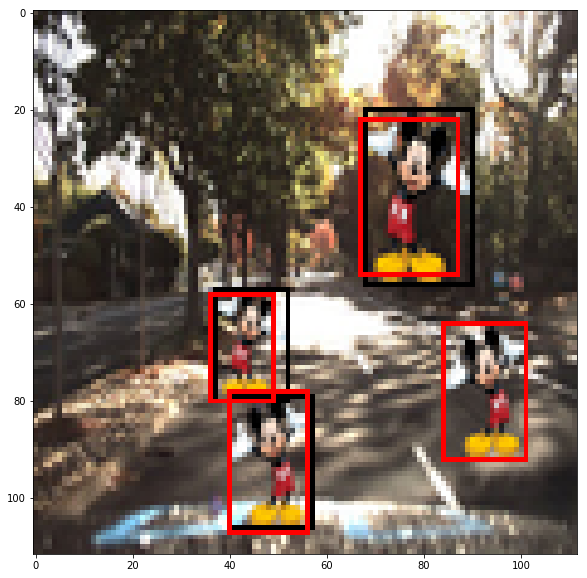

In [42]:
test_image = x_batch[img_num]*255.0

plt.rcParams['figure.figsize'] = 10, 10


plt.imshow(visual.draw_image_pred_GT(test_image, GT_rects_encoded[0], pred_rects_encoded[0]) )